<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Machine-Learning-and-Deep-Learning-Projects/blob/main/alpaca%20classification%20%20%5Btransfer%20learning%20with%20mobilenetv2%5D/alpaca_classification_%5Btransfer_learning_with_mobilenetv2%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alpaca Classifier using Transfer Learning with MobileNetv2**

We'll be using transfer learning on a pre-trained CNN to build an Alpaca/Not Alpaca classifier!

A pre-trained model is a network that's already been trained on a large dataset and saved which allows you to use it to customize your own model cheaply and efficiently. Here we'll be using **MobileNetV2** that was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

Here we will :

- create a dataset from a directory
- preprocess and augment data using the Sequential API
- adapt a pretrained model to new data and train a classifier using the Functional API and MobileNet
- fine-tune a classifier's final layers to improve accuracy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [ ]:
# importing data from zip file

from zipfile import ZipFile
file_name = "dataset.zip"

with ZipFile(file_name, "r") as zip:
  zip.extractall()
  print("Done")

Done


Generating a dataset from image files stored on disk is simple and fast. Call `image_data_set_from_directory()` to read from the directory and create both training and validation datasets. 

For specifying a validation split, we'll also need to specify the subset for each portion. Just set the training set to `subset='training'` and the validation set to `subset='validation'`.

we'll also set our seeds to match each other. So our training and validation sets don't overlap. :) 

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/Files/dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


Now let's take a look at some of the images from the training set:

**Note:** The original dataset has some mislabelled images in it as well.

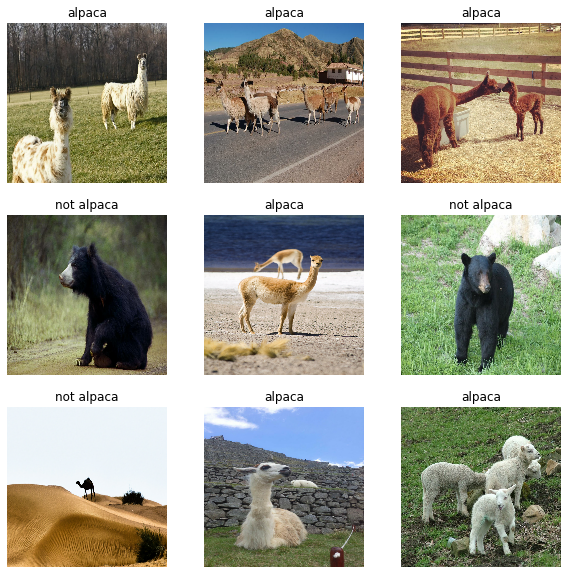

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### **Preprocess and Augment Training Data**

 

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from our input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

We can set the number of elements to prefetch manually, or we can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help our model learn the data better, it's standard practice to augment the images by transforming them. I.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of our model and can be re-used later.   

As always, one can read the official docs, which one can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

**Implementing a function for data augmentation.** Using a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [ ]:
# data augmenter
def data_augmenter():
   
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

Let's take a look at how an image from the training set has been augmented with simple transformations:

From one cute animal to 9 variations of that cute animal in three lines of code. Now our model has a lot more to learn from.

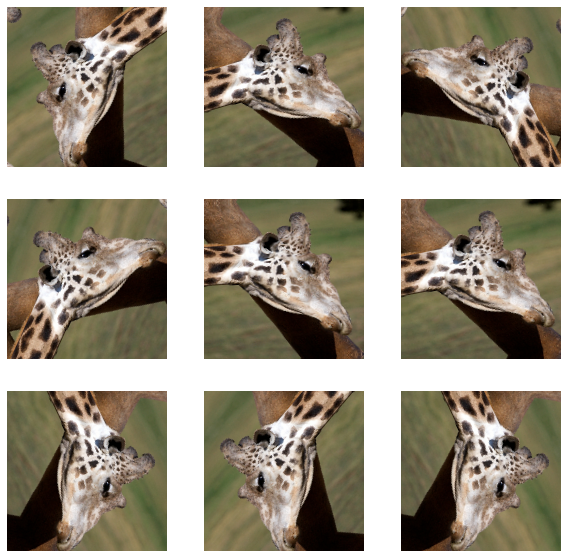

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

We'll apply our first tool from the MobileNet application in TensorFlow to normalize our input. Since we're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.





**We have to remember:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give our model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

**Using MobileNetV2 for Transfer Learning**

MobileNetV2 was trained on ImageNet and is optimized to run on mobile and other low-power applications. It's 155 layers deep and very efficient for object detection and image segmentation tasks as well as classification tasks like this one. The architecture has three defining characteristics:

*   Depthwise separable convolutions
*   Thin input and output bottlenecks between layers
*   Shortcut connections between bottleneck layers




Let's try to train our base model using all the layers from the pretrained model. 

Similarly to how we reused the pretrained normalization values MobileNetV2 was trained on, we'll also load the pretrained weights from ImageNet by specifying `weights='imagenet'`. 

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14548992/14536120 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

Note the last 2 layers here. They are the so called top layers and they are responsible of the classification in the model.

In [ ]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


choose the first batch from the tensorflow dataset to use the images and run it through the MobileNetV2 base model to test out the predictions on some of the images.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [ ]:
# Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

Now decode the predictions made by the model. Earlier when we printed the shape of the batch, it have returned (32, 1000). The number 32 refers to the batch size and 1000 refers to the 1000 classes the model was pretrained on. The predictions returned by the base model below follow this format:

First the class number then a human-readable label and last the probability of the image belonging to that class. We'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [ ]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.4258216),
  ('n02708093', 'analog_clock', 0.09275585)],
 [('n04589890', 'window_screen', 0.23985966),
  ('n03887697', 'paper_towel', 0.148026)],
 [('n04589890', 'window_screen', 0.74494594),
  ('n03598930', 'jigsaw_puzzle', 0.021948552)],
 [('n04589890', 'window_screen', 0.33546075),
  ('n03530642', 'honeycomb', 0.07628933)],
 [('n04589890', 'window_screen', 0.27327415),
  ('n03733281', 'maze', 0.08846921)],
 [('n04589890', 'window_screen', 0.6745244),
  ('n03530642', 'honeycomb', 0.07659898)],
 [('n04589890', 'window_screen', 0.7912851),
  ('n04209239', 'shower_curtain', 0.092416115)],
 [('n04589890', 'window_screen', 0.16463046),
  ('n03598930', 'jigsaw_puzzle', 0.08749096)],
 [('n03598930', 'jigsaw_puzzle', 0.37021345),
  ('n04589890', 'window_screen', 0.099569686)],
 [('n04589890', 'window_screen', 0.6161661),
  ('n03887697', 'paper_towel', 0.054876607)],
 [('n03530642', 'honeycomb', 0.25448883),
  ('n04589890', 'window_screen', 0.24874383)],
 [('

There's a whole lot of labels here. Some of them hilariously wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model all we get is a bunch of incorrectly classified images.

Fortunately, we can delete the top layer, which contains all the classification labels and create a new classification layer.

**Layer Freezing with Functional API**



Let's do this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

In [ ]:
# alpaca model

def alpaca_model(image_shape = IMG_SIZE, data_augmentation = data_augmenter()):
    
        # Defining a tf.keras model for binary classification out of the MobileNetV2 model
        # image_shape --> Image width and height
        # data_augmentation --> data augmentation function
        # Returns: tf.keras.model


    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape,
                                                   include_top = False, # <== Important!!!!
                                                   weights = 'imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tfl.Dense(1,'linear')(x)

    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Creating new model using the data_augmentation function defined earlier

In [ ]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9420800/9406464 [==============================] - 0s 0us/step


The base learning rate has been set, so we can go ahead and compile the new model and run it for 5 epochs:

In [ ]:
base_learning_rate = 0.001
model2.compile(optimizer = tf.keras.optimizers.Adam(lr = base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs = initial_epochs)

Epoch 1/5
9/9 [==============================] - 8s 505ms/step - loss: 0.8408 - accuracy: 0.4962 - val_loss: 0.4612 - val_accuracy: 0.7692
Epoch 2/5
9/9 [==============================] - 5s 434ms/step - loss: 0.6954 - accuracy: 0.5458 - val_loss: 0.4092 - val_accuracy: 0.7077
Epoch 3/5
9/9 [==============================] - 5s 427ms/step - loss: 0.5640 - accuracy: 0.6489 - val_loss: 0.3365 - val_accuracy: 0.8000
Epoch 4/5
9/9 [==============================] - 5s 431ms/step - loss: 0.4741 - accuracy: 0.7366 - val_loss: 0.3055 - val_accuracy: 0.8462
Epoch 5/5
9/9 [==============================] - 5s 436ms/step - loss: 0.4280 - accuracy: 0.7977 - val_loss: 0.2683 - val_accuracy: 0.8923


**Plotting the training and validation accuracy**

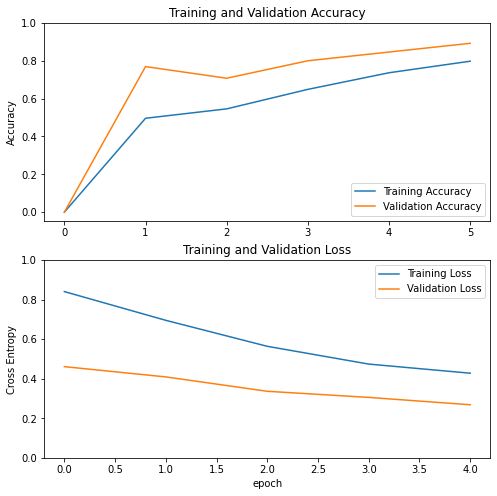

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
class_names

['alpaca', 'not alpaca']

**Fine Tuning The Model**

We could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When we use a smaller learning rate, we take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way we achieve this is by unfreezing the layers at the end of the network and then re-training our model on the final layers with a very low learning rate. Adapting our learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When we add new data, we generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to our data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of our network that contain the fine details (pointy ears, hairy tails) that are more specific to our problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs and see if our accuracy improved!

In [ ]:
base_model = model2.layers[4]
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 10s 660ms/step - loss: 0.5269 - accuracy: 0.7099 - val_loss: 0.2320 - val_accuracy: 0.8462
Epoch 6/10
9/9 [==============================] - 6s 586ms/step - loss: 0.3199 - accuracy: 0.8282 - val_loss: 0.2457 - val_accuracy: 0.9231
Epoch 7/10
9/9 [==============================] - 6s 592ms/step - loss: 0.2714 - accuracy: 0.8740 - val_loss: 0.1419 - val_accuracy: 0.9538
Epoch 8/10
9/9 [==============================] - 6s 576ms/step - loss: 0.2389 - accuracy: 0.9084 - val_loss: 0.1145 - val_accuracy: 0.9538
Epoch 9/10
9/9 [==============================] - 6s 586ms/step - loss: 0.1572 - accuracy: 0.9427 - val_loss: 0.0598 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 6s 584ms/step - loss: 0.1700 - accuracy: 0.9198 - val_loss: 0.0401 - val_accuracy: 1.0000


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

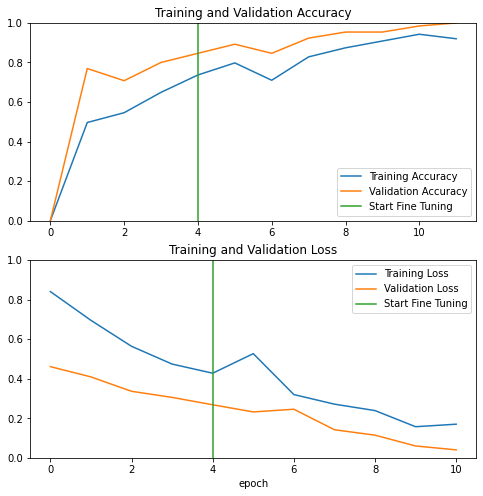

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()